In [2]:
import numpy as np
import pandas as pd
import os
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import metrics
import seaborn as seabornInstance 
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,12
import datetime

# Data Reading + Date time conversion

In [3]:
df1 = pd.read_csv('https://raw.githubusercontent.com/avi30ch/CrimeChicago/main/Fall2020ASDRP.csv')
df1.shape

(605297, 2)

In [4]:
df1.dropna(inplace = True)
df1.tail()

,Date,Frequency
605292,12/31/16 0:30,2.0
605293,12/31/16 12:30,3.0
605294,12/31/16 12:34,1.0
605295,12/31/16 12:40,1.0
605296,12/31/16 12:45,1.0


In [5]:
df1['Date'] = pd.to_datetime(df1['Date'], infer_datetime_format = True)
df1['Date'] = df1['Date'].dt.date

In [6]:
df2 = df1.groupby(['Date']).sum()

In [7]:
df2.head(20)
df2.shape
df2_c = df2.copy
x = df2.Frequency.values
print(len(x) * 0.33)

1934.46


In [8]:
df2.tail(20)

,Frequency
Date,
2016-12-30,165.0
2016-12-31,149.0
2017-01-01,153.0
2017-01-02,112.0
2017-01-03,132.0
2017-01-04,156.0
2017-01-05,122.0
2017-01-06,118.0
2017-01-07,114.0


# Plots for the Theft Data

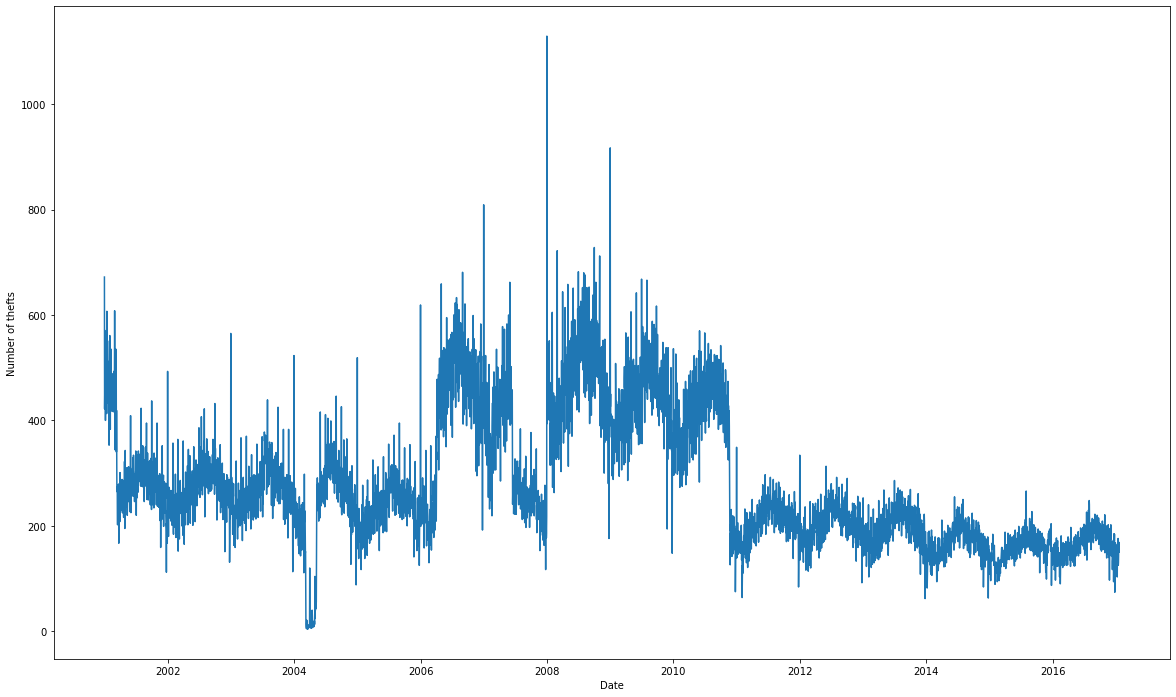

In [9]:
plt.xlabel("Date")
plt.ylabel("Number of thefts")#change to num of thefts
plt.plot(df2)

In [10]:
rolmean = df2.rolling(window=365).mean()
#change to 365 since we are doing days not months

rolstd = df2.rolling(window=365).std()

In [11]:
rolmean.head(365)

,Frequency
Date,
2001-01-01,NaN
2001-01-02,NaN
2001-01-03,NaN
2001-01-04,NaN
2001-01-05,NaN
...,...
2001-12-27,NaN
2001-12-28,NaN
2001-12-29,NaN


In [12]:
rolstd.head(365)

,Frequency
Date,
2001-01-01,NaN
2001-01-02,NaN
2001-01-03,NaN
2001-01-04,NaN
2001-01-05,NaN
...,...
2001-12-27,NaN
2001-12-28,NaN
2001-12-29,NaN


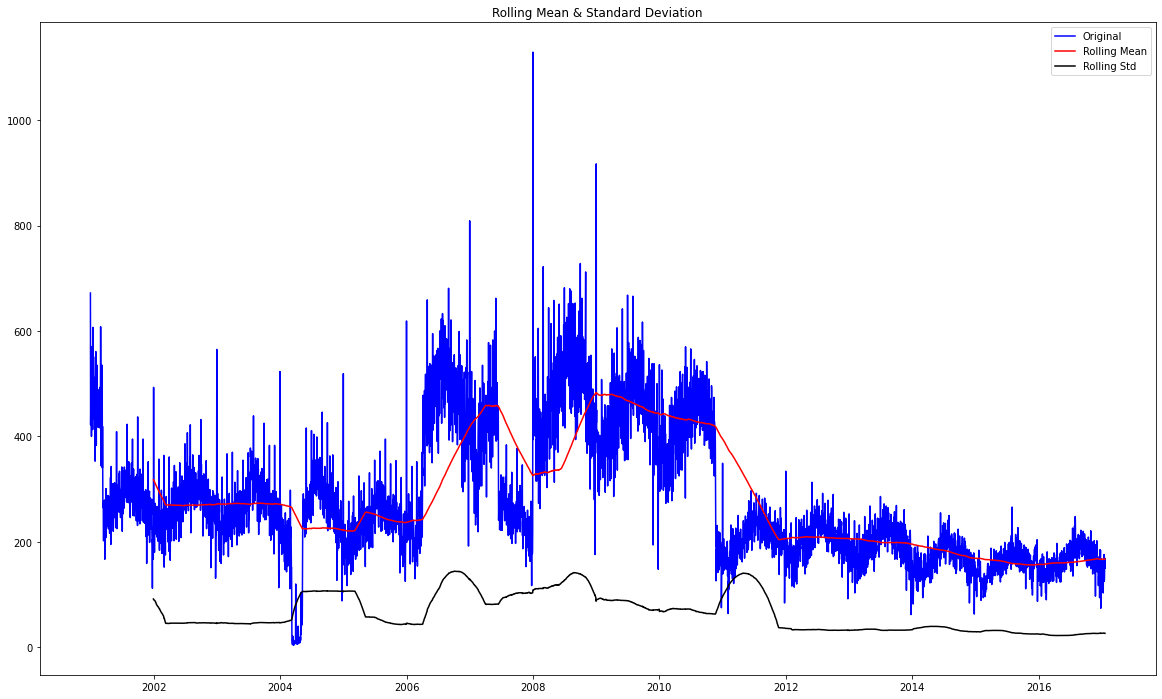

In [13]:
orig = plt.plot(df2, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color= 'black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)
#the data is not stationary

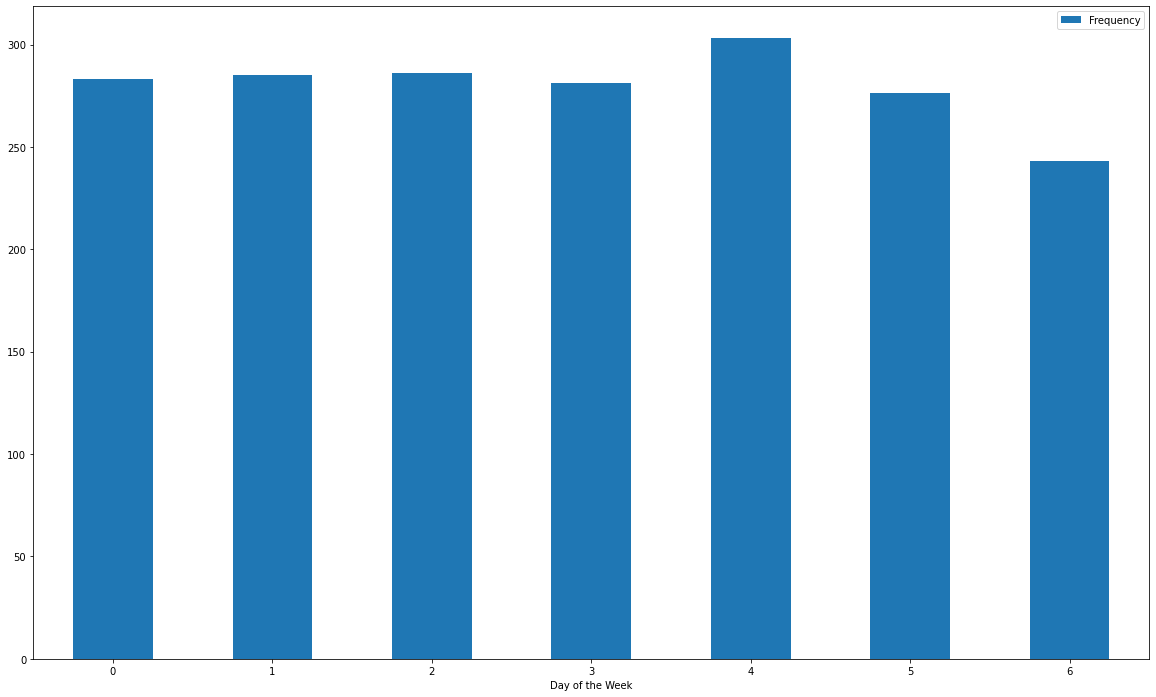

In [14]:
#bar plot for days of the week
s = pd.date_range('2001-01-01', '2017-01-18', freq='D').to_series()
s.dt.dayofweek
df3 = df2.copy()
df3.insert(1, "Day of the Week", s.dt.dayofweek, True) 
df3 = df3.groupby(['Day of the Week']).sum()
df3['Frequency'] = df3['Frequency'].apply(lambda x: x/837.285714286)
df3.head(7)
df3.reset_index(inplace = True)
df3.plot.bar(x='Day of the Week', y='Frequency', rot=0)
# why does it drop on Sunday, and why does it spike on Friday
#theory==> People go to parties on Friday, Friday is the day that people go out
#Sunday==> people stay at home so thieves dont break in

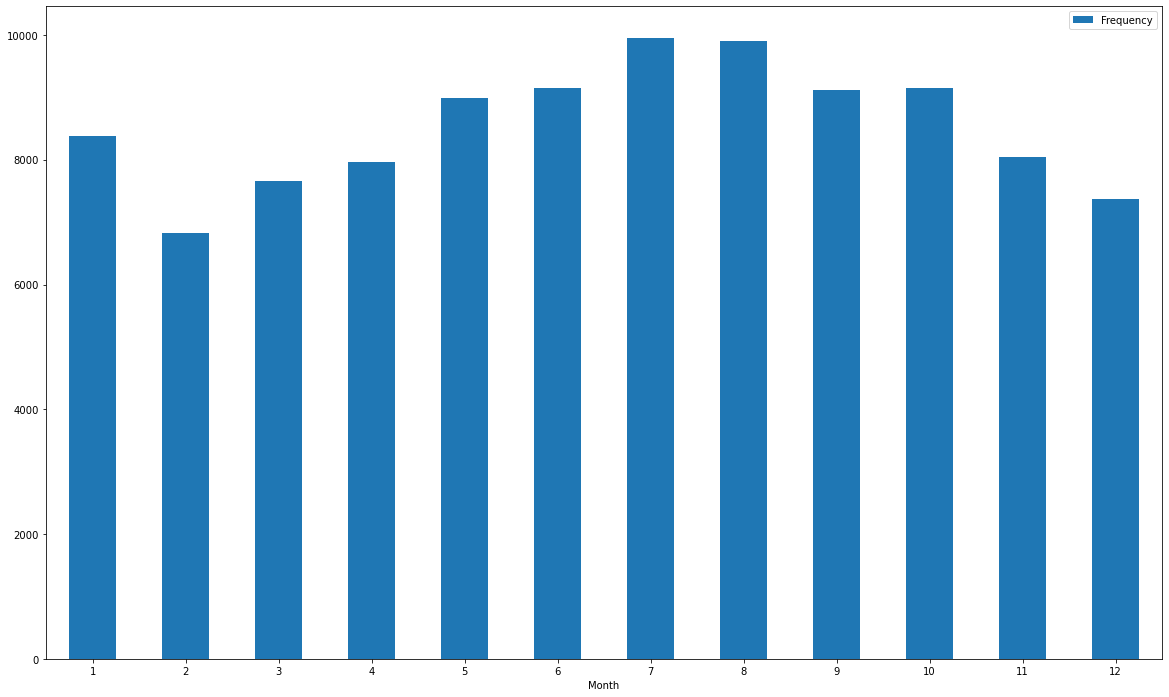

In [15]:
#bar plot for months
s2 = pd.date_range('2001-01-01', '2017-01-18', freq='D').to_series()
s2.dt.month
df4 = df2.copy()
df4.insert(1, "Month", s.dt.month, True) 
df4 = df4.groupby(['Month']).sum()
df4.head(13)

df4['Frequency'] = df4['Frequency'].apply(lambda x: x/16)
df4.head(12)
df4.reset_index(inplace = True)
df4.plot.bar(x='Month', y='Frequency', rot=0)
#make predictions

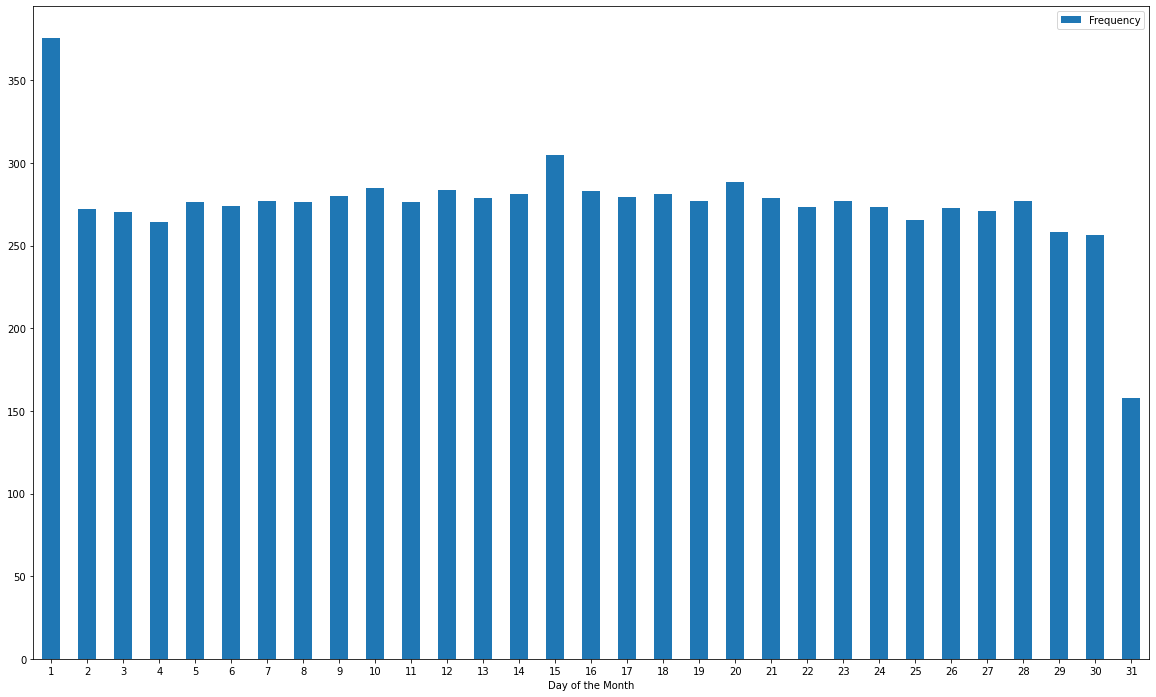

In [16]:
#bar plot for days of month
s3 = pd.date_range('2001-01-01', '2017-01-18', freq='D').to_series()
s2.dt.day
df5 = df2.copy()
df5.insert(1, "Day of the Month", s.dt.day, True) 
df5 = df5.groupby(['Day of the Month']).sum()
df5.head(31)

df5['Frequency'] = df5['Frequency'].apply(lambda x: x/192)
df5.head(12)
df5.reset_index(inplace = True)
df5.plot.bar(x='Day of the Month', y='Frequency', rot=0)
#make predictions



```
# This is formatted as code
```

# Dickey Fuller Test + Log changes to Original Data set


In [17]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window=365).mean()
    rolstd = timeseries.rolling(window=365).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

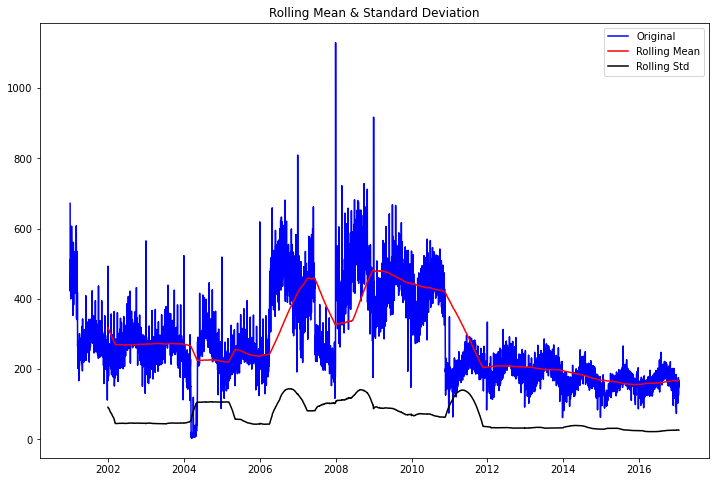

Results of Dickey-Fuller Test:
Test Statistic                   -2.954845
p-value                           0.039332
#Lags Used                       34.000000
Number of Observations Used    5827.000000
Critical Value (1%)              -3.431473
Critical Value (5%)              -2.862036
Critical Value (10%)             -2.567034
dtype: float64


In [18]:
test_stationarity(df2)

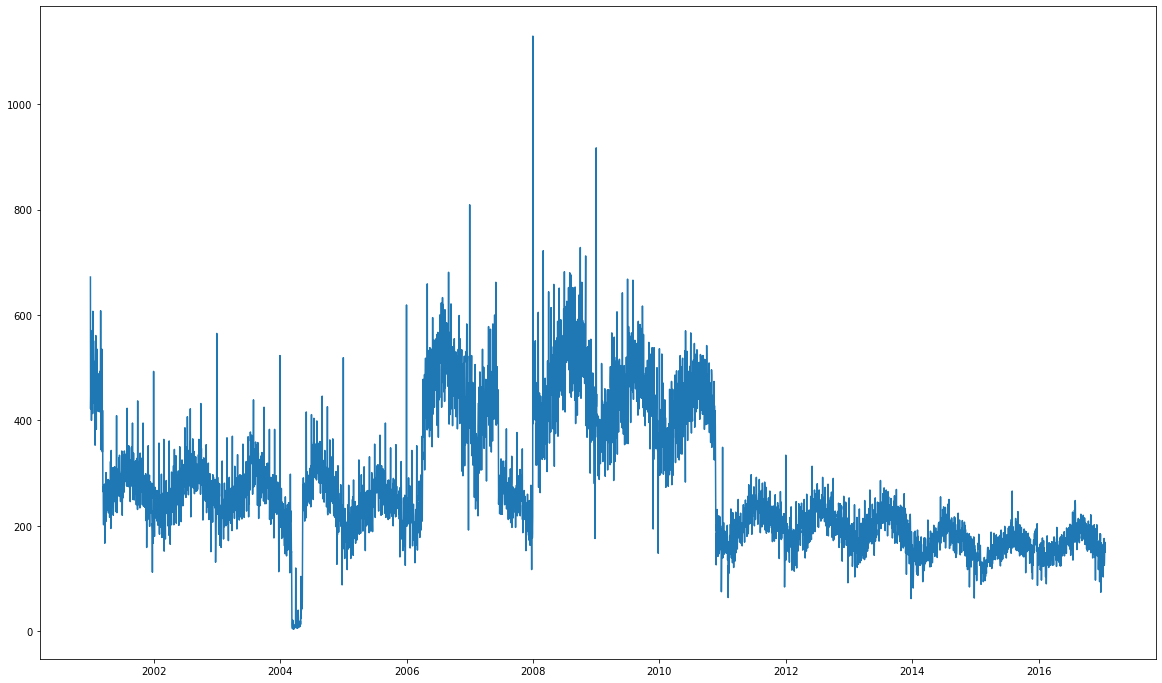

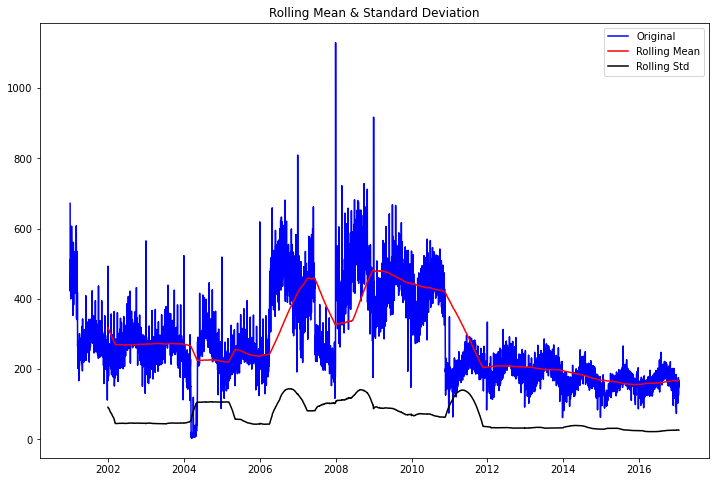

Results of Dickey-Fuller Test:
Test Statistic                   -2.954845
p-value                           0.039332
#Lags Used                       34.000000
Number of Observations Used    5827.000000
Critical Value (1%)              -3.431473
Critical Value (5%)              -2.862036
Critical Value (10%)             -2.567034
dtype: float64


In [19]:
df2_logScale = np.log(df2)
plt.plot(df2)
test_stationarity(df2)
# got it pretty stationary because of low p val

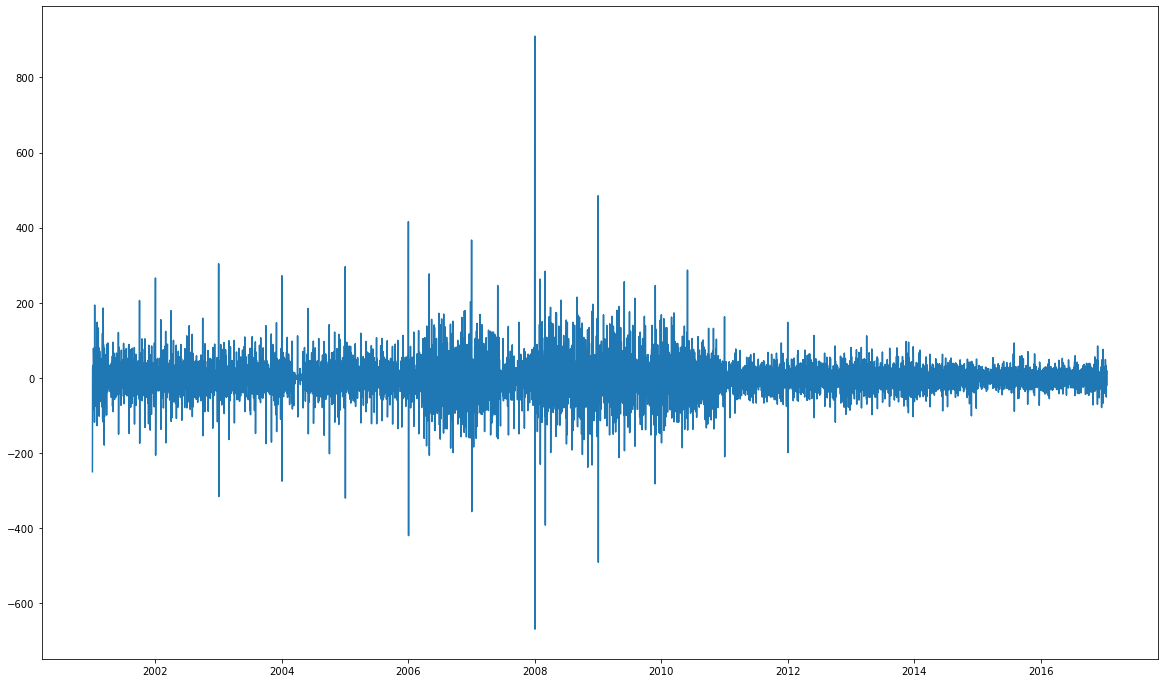

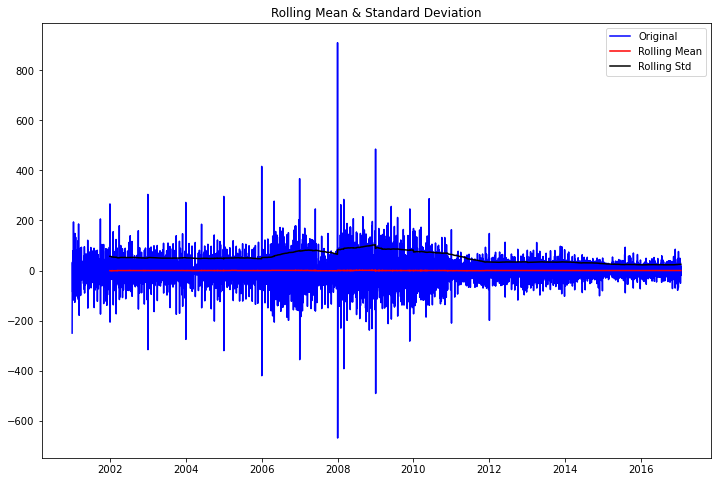

Results of Dickey-Fuller Test:
Test Statistic                -1.422331e+01
p-value                        1.643561e-26
#Lags Used                     3.400000e+01
Number of Observations Used    5.826000e+03
Critical Value (1%)           -3.431473e+00
Critical Value (5%)           -2.862036e+00
Critical Value (10%)          -2.567034e+00
dtype: float64


In [20]:
datasetLogDiffShifting = df2_logScale - df2_logScale.shift()
datasetDiffShifting = df2 - df2.shift()
plt.plot(datasetDiffShifting)
datasetDiffShifting.dropna(inplace=True)
test_stationarity(datasetDiffShifting)

<ipython-input-21-3345d4ebd063>:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decomposition = seasonal_decompose(df2_logScale, model = 'additive', filt = None, freq=365, two_sided = True, extrapolate_trend=1)


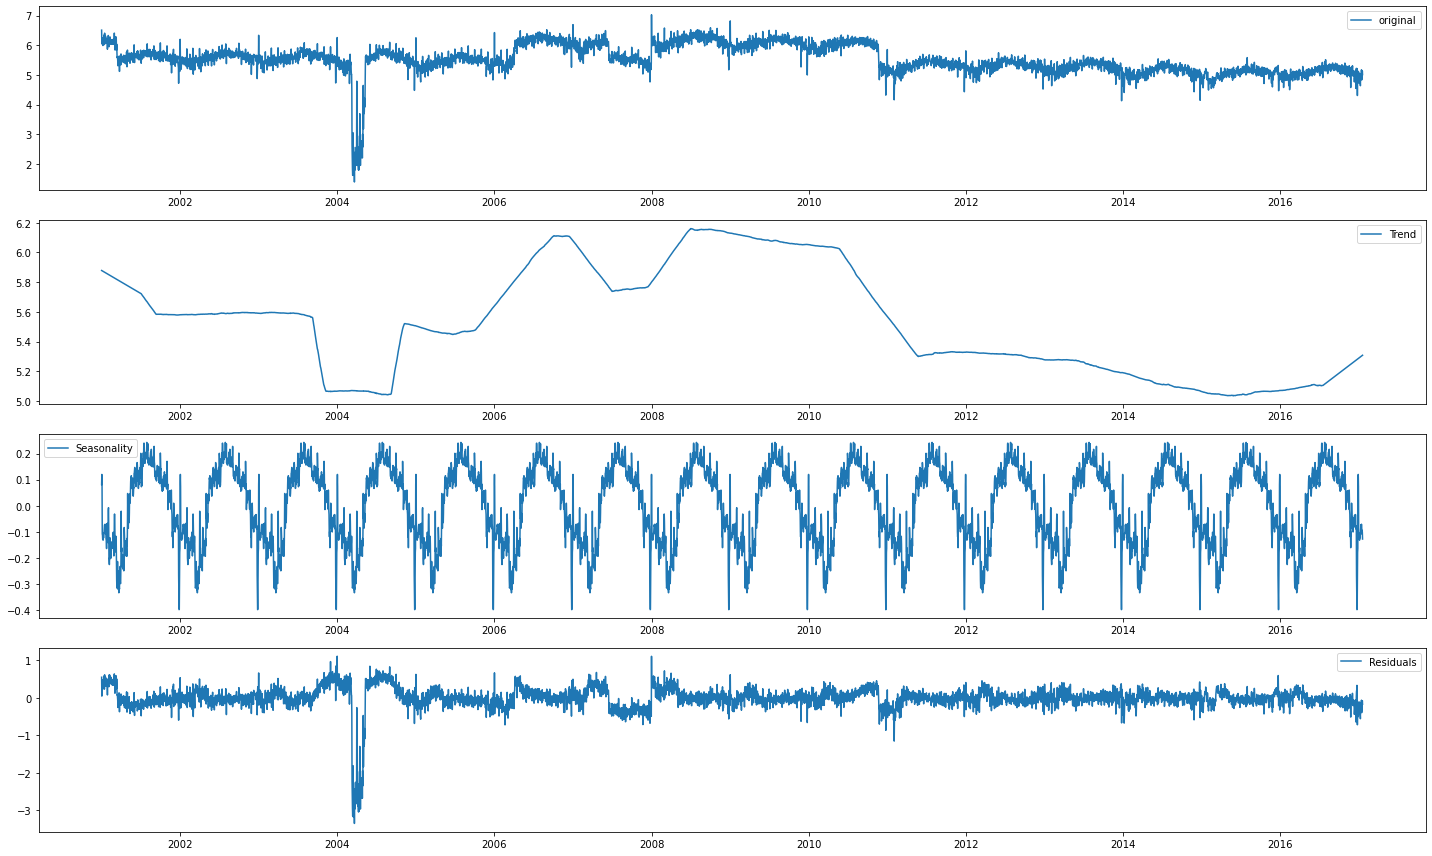

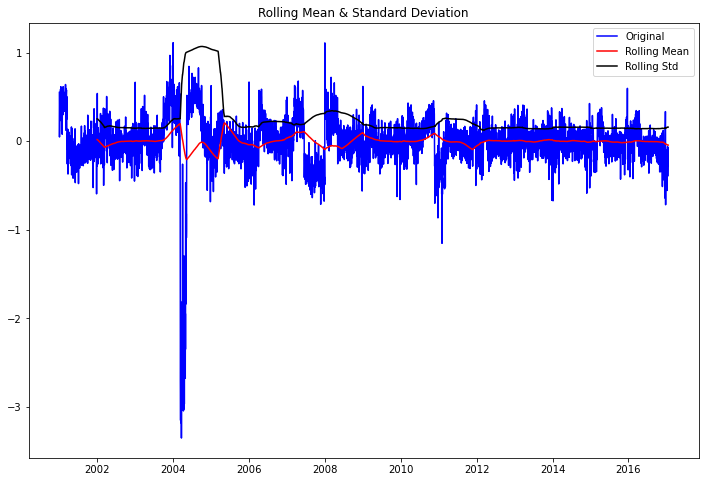

Results of Dickey-Fuller Test:
Test Statistic                -9.156326e+00
p-value                        2.603900e-15
#Lags Used                     3.400000e+01
Number of Observations Used    5.827000e+03
Critical Value (1%)           -3.431473e+00
Critical Value (5%)           -2.862036e+00
Critical Value (10%)          -2.567034e+00
dtype: float64


In [21]:
# checks individual bits of time series
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df2_logScale, model = 'additive', filt = None, freq=365, two_sided = True, extrapolate_trend=1)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(df2_logScale, label="original")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label="Trend")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label="Seasonality")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label="Residuals")
plt.legend(loc='best')
plt.tight_layout()

decomposedLogData = residual
decomposedLogData.dropna(inplace=True)
test_stationarity(decomposedLogData)

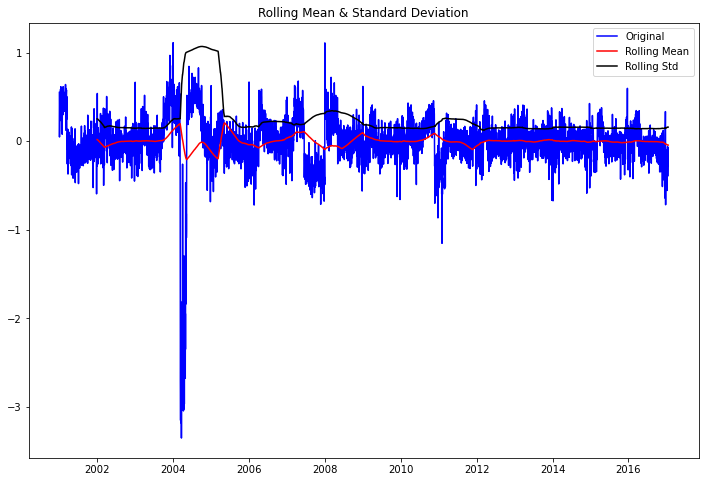

Results of Dickey-Fuller Test:
Test Statistic                -9.156326e+00
p-value                        2.603900e-15
#Lags Used                     3.400000e+01
Number of Observations Used    5.827000e+03
Critical Value (1%)           -3.431473e+00
Critical Value (5%)           -2.862036e+00
Critical Value (10%)          -2.567034e+00
dtype: float64


In [22]:
decomposedLogData = residual
decomposedLogData.dropna(inplace=True)
test_stationarity(decomposedLogData)

/Users/avichoudhary/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:568: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


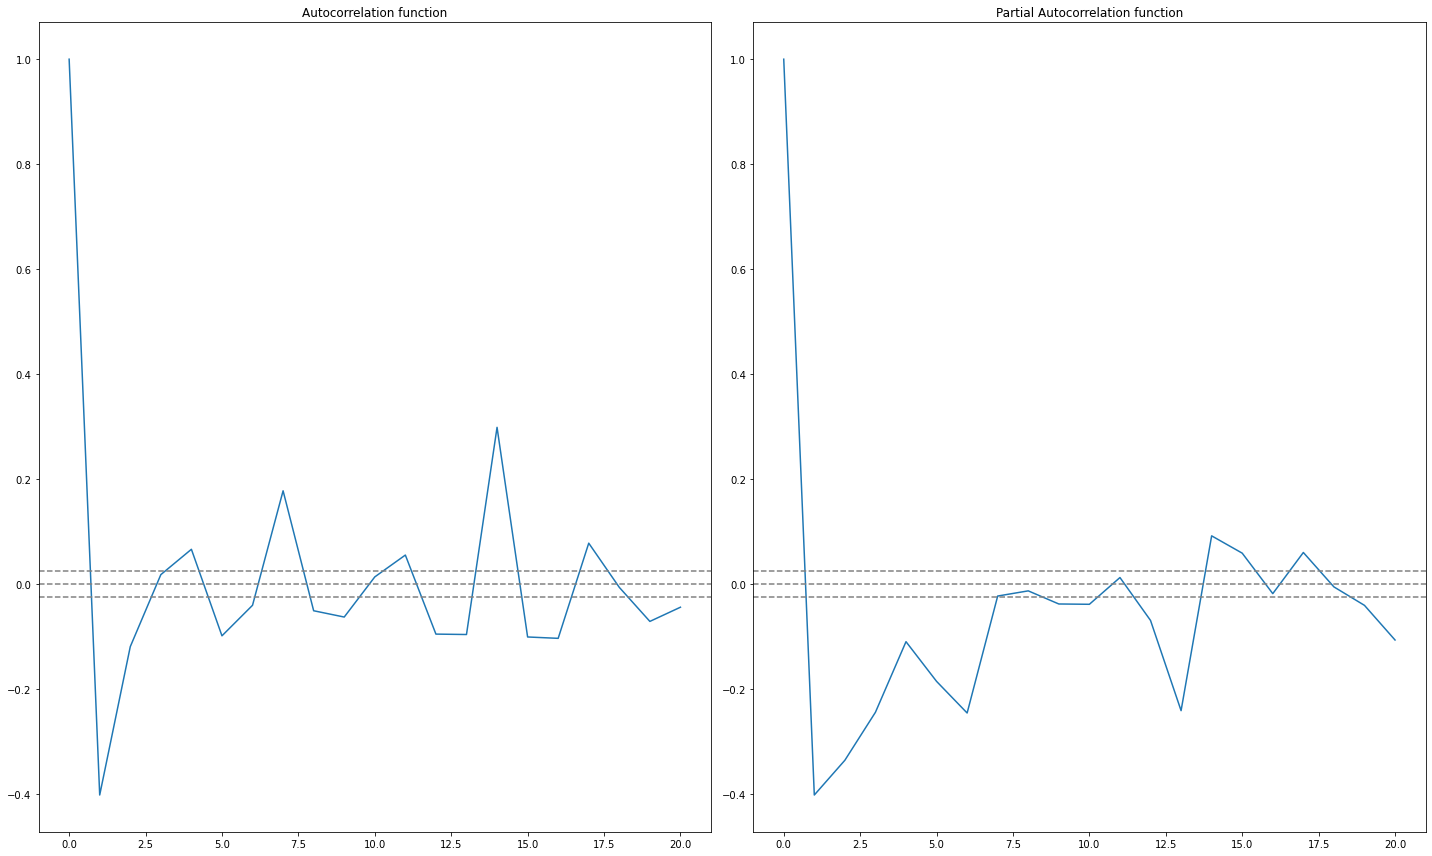

In [23]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(datasetDiffShifting, nlags=20)
lag_pacf = pacf(datasetDiffShifting, nlags=20, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetDiffShifting)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetDiffShifting)),linestyle='--',color ='gray')
plt.title('Autocorrelation function')

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetDiffShifting)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetDiffShifting)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation function')
plt.tight_layout()

In [24]:
datasetDiffShifting.reset_index(inplace = True)
datasetDiffShifting.head()

,Date,Frequency
0,2001-01-02,-250.0
1,2001-01-03,25.0
2,2001-01-04,33.0
3,2001-01-05,33.0
4,2001-01-06,-27.0


In [25]:
datasetDiffShifting.Date = pd.to_datetime(datasetDiffShifting.Date)
df2.reset_index(inplace = True)
df2.head()

,Date,Frequency
0,2001-01-01,672.0
1,2001-01-02,422.0
2,2001-01-03,447.0
3,2001-01-04,480.0
4,2001-01-05,513.0


In [26]:
df2.Date = pd.to_datetime(df2.Date)
print(df2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5862 entries, 0 to 5861
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       5862 non-null   datetime64[ns]
 1   Frequency  5862 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 91.7 KB
None


# ARIMA Model Implementation


In [27]:
#X = df2['Date']
#y = df2['Frequency']
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.332)
train = df2[:int(0.7*(len(datasetLogDiffShifting)))]
test = df2[int(0.7*(len(datasetLogDiffShifting))):]
#train_log = np.log(train)
#plt.plot(ts_log)
trainShift = train - train.shift()
trainShift.Frequency = train.Frequency - train.Frequency.shift()
trainShift.dropna(inplace=True)

In [28]:
df2.tail()

,Date,Frequency
5857,2017-01-14,125.0
5858,2017-01-15,131.0
5859,2017-01-16,151.0
5860,2017-01-17,169.0
5861,2017-01-18,150.0


In [29]:
train.tail()

,Date,Frequency
4098,2012-03-22,219.0
4099,2012-03-23,236.0
4100,2012-03-24,201.0
4101,2012-03-25,163.0
4102,2012-03-26,191.0


In [30]:
trainShift.head()

,Date,Frequency
1,1 days,-250.0
2,1 days,25.0
3,1 days,33.0
4,1 days,33.0
5,1 days,-27.0


Plotting AR model


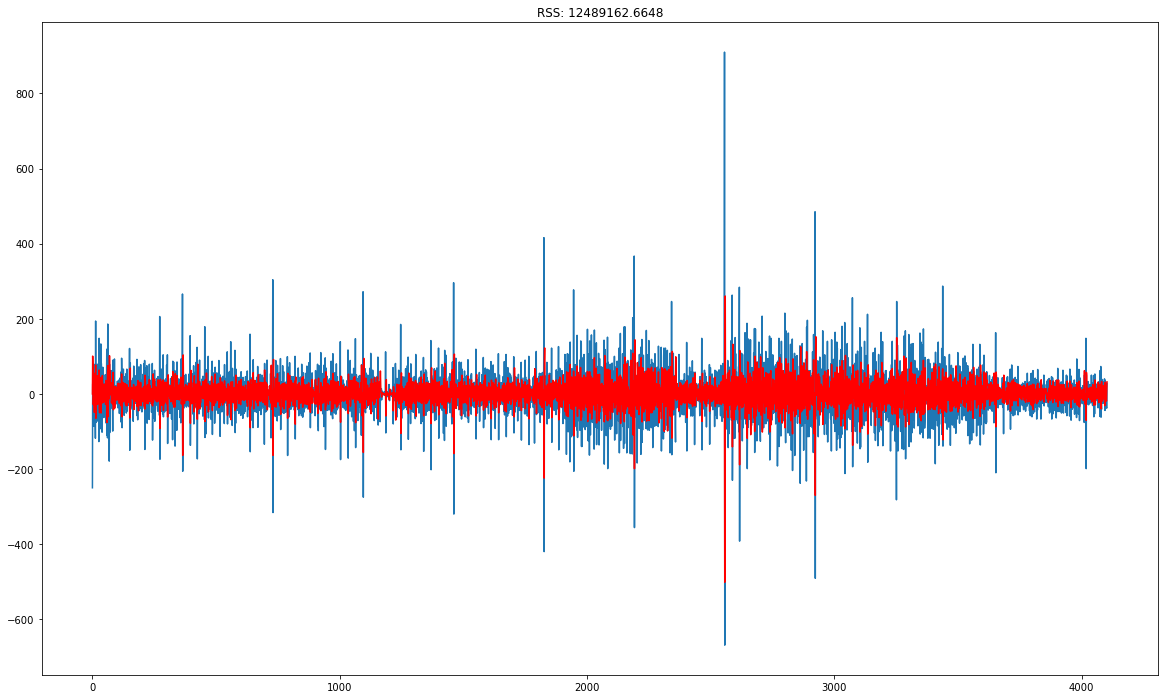

In [31]:
#Auto Regressive
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train.Frequency, order = (2, 1, 0))
results_AR = model.fit(disp = -1)
plt.plot(trainShift.Frequency)
plt.plot(results_AR.fittedvalues, color = "red")
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-trainShift['Frequency'])**2))
print("Plotting AR model")


Plotting AR model


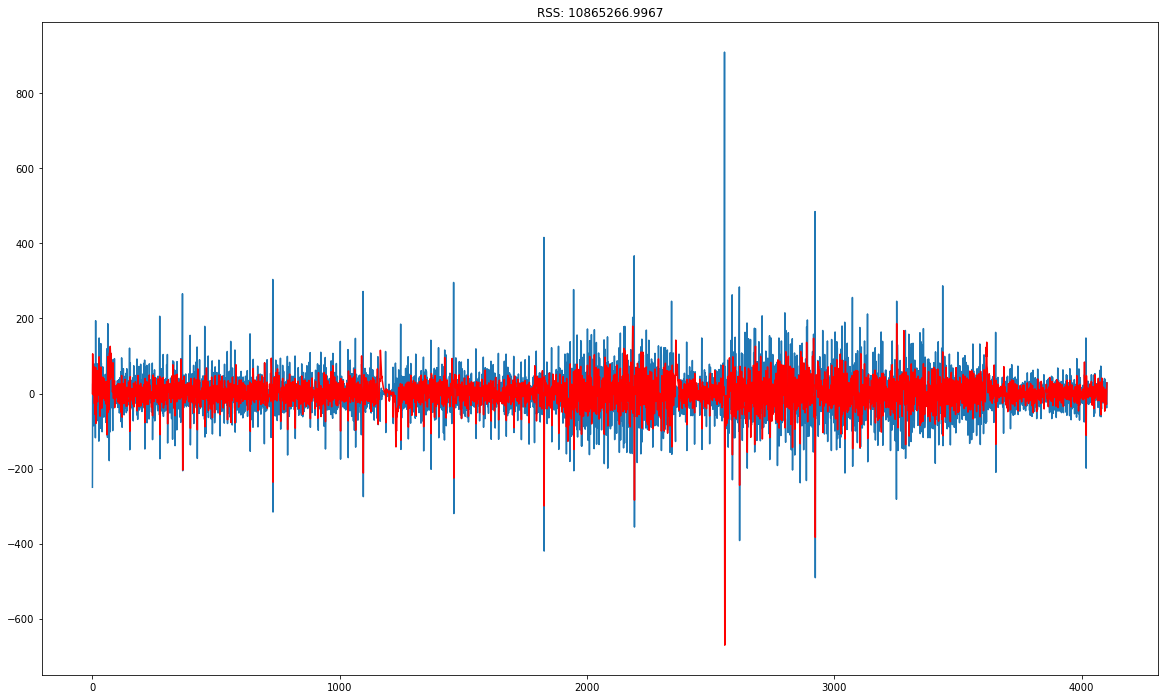

In [32]:
#Moving Average
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train.Frequency, order = (0, 1, 2))
results_MA = model.fit(disp = -1)
plt.plot(trainShift.Frequency)
plt.plot(results_MA.fittedvalues, color = "red")
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-trainShift['Frequency'])**2))
print("Plotting AR model")


In [33]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train.Frequency, order=(5,1,0))
model_fit = model.fit()

In [34]:
X = df2.Frequency.values
X.shape
size = int(len(X) * 0.7)
df2_train, df2_test = df2[0:size], df2[size:len(X)]
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

In [35]:
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = round(float(np.asarray(output[0])))
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=199.000000, expected=187.000000
predicted=194.000000, expected=236.000000
predicted=209.000000, expected=211.000000
predicted=201.000000, expected=210.000000
predicted=200.000000, expected=195.000000
predicted=205.000000, expected=243.000000
predicted=216.000000, expected=202.000000
predicted=212.000000, expected=218.000000
predicted=215.000000, expected=206.000000
predicted=213.000000, expected=215.000000
predicted=210.000000, expected=227.000000
predicted=222.000000, expected=205.000000
predicted=209.000000, expected=154.000000
predicted=196.000000, expected=228.000000
predicted=212.000000, expected=213.000000
predicted=204.000000, expected=190.000000
predicted=199.000000, expected=183.000000
predicted=199.000000, expected=208.000000
predicted=194.000000, expected=237.000000
predicted=214.000000, expected=235.000000
predicted=215.000000, expected=250.000000
predicted=225.000000, expected=227.000000
predicted=223.000000, expected=201.000000
predicted=220.000000, expected=186

predicted=205.000000, expected=188.000000
predicted=191.000000, expected=208.000000
predicted=202.000000, expected=194.000000
predicted=192.000000, expected=228.000000
predicted=203.000000, expected=208.000000
predicted=207.000000, expected=182.000000
predicted=196.000000, expected=212.000000
predicted=210.000000, expected=190.000000
predicted=196.000000, expected=210.000000
predicted=207.000000, expected=213.000000
predicted=206.000000, expected=210.000000
predicted=201.000000, expected=207.000000
predicted=209.000000, expected=183.000000
predicted=197.000000, expected=203.000000
predicted=205.000000, expected=204.000000
predicted=203.000000, expected=221.000000
predicted=207.000000, expected=218.000000
predicted=209.000000, expected=226.000000
predicted=211.000000, expected=209.000000
predicted=213.000000, expected=185.000000
predicted=205.000000, expected=210.000000
predicted=213.000000, expected=228.000000
predicted=214.000000, expected=185.000000
predicted=202.000000, expected=243

/Users/avichoudhary/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


predicted=173.000000, expected=181.000000
predicted=174.000000, expected=152.000000
predicted=173.000000, expected=206.000000
predicted=190.000000, expected=188.000000
predicted=182.000000, expected=178.000000
predicted=182.000000, expected=165.000000
predicted=180.000000, expected=240.000000
predicted=195.000000, expected=173.000000
predicted=185.000000, expected=103.000000
predicted=162.000000, expected=155.000000
predicted=173.000000, expected=172.000000
predicted=160.000000, expected=161.000000
predicted=166.000000, expected=168.000000
predicted=164.000000, expected=190.000000
predicted=162.000000, expected=181.000000
predicted=171.000000, expected=153.000000
predicted=168.000000, expected=173.000000
predicted=173.000000, expected=171.000000
predicted=170.000000, expected=180.000000
predicted=175.000000, expected=148.000000
predicted=165.000000, expected=216.000000
predicted=182.000000, expected=157.000000
predicted=168.000000, expected=121.000000
predicted=157.000000, expected=147

predicted=223.000000, expected=257.000000
predicted=231.000000, expected=181.000000
predicted=209.000000, expected=260.000000
predicted=239.000000, expected=265.000000
predicted=237.000000, expected=265.000000
predicted=242.000000, expected=237.000000
predicted=250.000000, expected=240.000000
predicted=238.000000, expected=255.000000
predicted=254.000000, expected=207.000000
predicted=235.000000, expected=234.000000
predicted=242.000000, expected=230.000000
predicted=232.000000, expected=216.000000
predicted=225.000000, expected=202.000000
predicted=224.000000, expected=221.000000
predicted=218.000000, expected=240.000000
predicted=226.000000, expected=229.000000
predicted=223.000000, expected=224.000000
predicted=224.000000, expected=211.000000
predicted=219.000000, expected=219.000000
predicted=222.000000, expected=215.000000
predicted=221.000000, expected=252.000000
predicted=230.000000, expected=223.000000
predicted=223.000000, expected=251.000000
predicted=233.000000, expected=228

predicted=152.000000, expected=129.000000
predicted=144.000000, expected=128.000000
predicted=142.000000, expected=144.000000
predicted=148.000000, expected=145.000000
predicted=140.000000, expected=141.000000
predicted=146.000000, expected=130.000000
predicted=136.000000, expected=148.000000
predicted=140.000000, expected=140.000000
predicted=140.000000, expected=95.000000
predicted=125.000000, expected=94.000000
predicted=122.000000, expected=117.000000
predicted=119.000000, expected=150.000000
predicted=127.000000, expected=142.000000
predicted=127.000000, expected=165.000000
predicted=135.000000, expected=145.000000
predicted=136.000000, expected=121.000000
predicted=135.000000, expected=177.000000
predicted=158.000000, expected=115.000000
predicted=134.000000, expected=128.000000
predicted=141.000000, expected=138.000000
predicted=140.000000, expected=174.000000
predicted=142.000000, expected=177.000000
predicted=158.000000, expected=128.000000
predicted=139.000000, expected=152.0

predicted=190.000000, expected=198.000000
predicted=191.000000, expected=170.000000
predicted=185.000000, expected=156.000000
predicted=175.000000, expected=188.000000
predicted=184.000000, expected=140.000000
predicted=169.000000, expected=160.000000
predicted=170.000000, expected=182.000000
predicted=170.000000, expected=146.000000
predicted=154.000000, expected=154.000000
predicted=165.000000, expected=177.000000
predicted=163.000000, expected=177.000000
predicted=164.000000, expected=191.000000
predicted=177.000000, expected=189.000000
predicted=175.000000, expected=203.000000
predicted=185.000000, expected=173.000000
predicted=182.000000, expected=194.000000
predicted=189.000000, expected=176.000000
predicted=185.000000, expected=224.000000
predicted=198.000000, expected=190.000000
predicted=193.000000, expected=168.000000
predicted=183.000000, expected=204.000000
predicted=199.000000, expected=201.000000
predicted=190.000000, expected=196.000000
predicted=198.000000, expected=185

/Users/avichoudhary/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


predicted=178.000000, expected=190.000000
predicted=189.000000, expected=181.000000
predicted=179.000000, expected=174.000000
predicted=180.000000, expected=175.000000
predicted=178.000000, expected=153.000000
predicted=169.000000, expected=176.000000
predicted=176.000000, expected=190.000000
predicted=177.000000, expected=207.000000
predicted=183.000000, expected=179.000000
predicted=181.000000, expected=179.000000
predicted=181.000000, expected=201.000000
predicted=191.000000, expected=149.000000
predicted=174.000000, expected=143.000000
predicted=173.000000, expected=193.000000
predicted=179.000000, expected=147.000000
predicted=159.000000, expected=144.000000
predicted=163.000000, expected=180.000000
predicted=166.000000, expected=160.000000
predicted=155.000000, expected=143.000000
predicted=160.000000, expected=157.000000
predicted=158.000000, expected=157.000000
predicted=153.000000, expected=123.000000
predicted=147.000000, expected=165.000000
predicted=156.000000, expected=168

predicted=152.000000, expected=145.000000
predicted=156.000000, expected=178.000000
predicted=157.000000, expected=167.000000
predicted=160.000000, expected=137.000000
predicted=150.000000, expected=159.000000
predicted=159.000000, expected=149.000000
predicted=151.000000, expected=164.000000
predicted=159.000000, expected=179.000000
predicted=165.000000, expected=171.000000
predicted=160.000000, expected=169.000000
predicted=167.000000, expected=173.000000
predicted=168.000000, expected=155.000000
predicted=164.000000, expected=153.000000
predicted=165.000000, expected=160.000000
predicted=163.000000, expected=138.000000
predicted=153.000000, expected=155.000000
predicted=157.000000, expected=182.000000
predicted=162.000000, expected=179.000000
predicted=162.000000, expected=134.000000
predicted=155.000000, expected=124.000000
predicted=148.000000, expected=162.000000
predicted=156.000000, expected=158.000000
predicted=153.000000, expected=174.000000
predicted=161.000000, expected=192

predicted=155.000000, expected=164.000000
predicted=159.000000, expected=150.000000
predicted=157.000000, expected=163.000000
predicted=157.000000, expected=124.000000
predicted=147.000000, expected=112.000000
predicted=136.000000, expected=149.000000
predicted=147.000000, expected=135.000000
predicted=134.000000, expected=146.000000
predicted=141.000000, expected=99.000000
predicted=123.000000, expected=163.000000
predicted=139.000000, expected=137.000000
predicted=136.000000, expected=125.000000
predicted=130.000000, expected=159.000000
predicted=148.000000, expected=153.000000
predicted=136.000000, expected=169.000000
predicted=155.000000, expected=173.000000
predicted=158.000000, expected=162.000000
predicted=155.000000, expected=150.000000
predicted=160.000000, expected=149.000000
predicted=157.000000, expected=179.000000
predicted=166.000000, expected=186.000000
predicted=169.000000, expected=171.000000
predicted=167.000000, expected=172.000000
predicted=170.000000, expected=190.

predicted=165.000000, expected=174.000000
predicted=169.000000, expected=177.000000
predicted=172.000000, expected=177.000000
predicted=166.000000, expected=162.000000
predicted=169.000000, expected=170.000000
predicted=169.000000, expected=168.000000
predicted=170.000000, expected=149.000000
predicted=163.000000, expected=175.000000
predicted=170.000000, expected=148.000000
predicted=158.000000, expected=196.000000
predicted=173.000000, expected=195.000000
predicted=176.000000, expected=194.000000
predicted=177.000000, expected=177.000000
predicted=183.000000, expected=170.000000
predicted=176.000000, expected=165.000000
predicted=180.000000, expected=193.000000
predicted=184.000000, expected=182.000000
predicted=180.000000, expected=185.000000
predicted=180.000000, expected=174.000000
predicted=178.000000, expected=170.000000
predicted=175.000000, expected=188.000000
predicted=184.000000, expected=162.000000
predicted=172.000000, expected=183.000000
predicted=179.000000, expected=197

predicted=140.000000, expected=166.000000
predicted=145.000000, expected=136.000000
predicted=138.000000, expected=162.000000
predicted=146.000000, expected=173.000000
predicted=155.000000, expected=94.000000
predicted=131.000000, expected=142.000000
predicted=150.000000, expected=185.000000
predicted=153.000000, expected=179.000000
predicted=154.000000, expected=171.000000
predicted=166.000000, expected=184.000000
predicted=163.000000, expected=142.000000
predicted=159.000000, expected=74.000000
predicted=141.000000, expected=150.000000
predicted=154.000000, expected=140.000000
predicted=138.000000, expected=168.000000
predicted=147.000000, expected=135.000000
predicted=140.000000, expected=165.000000
predicted=141.000000, expected=149.000000
predicted=151.000000, expected=153.000000
predicted=149.000000, expected=112.000000
predicted=143.000000, expected=132.000000
predicted=139.000000, expected=156.000000
predicted=147.000000, expected=122.000000
predicted=131.000000, expected=118.0

In [36]:
#staring predictions
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 23.296


(1759,)

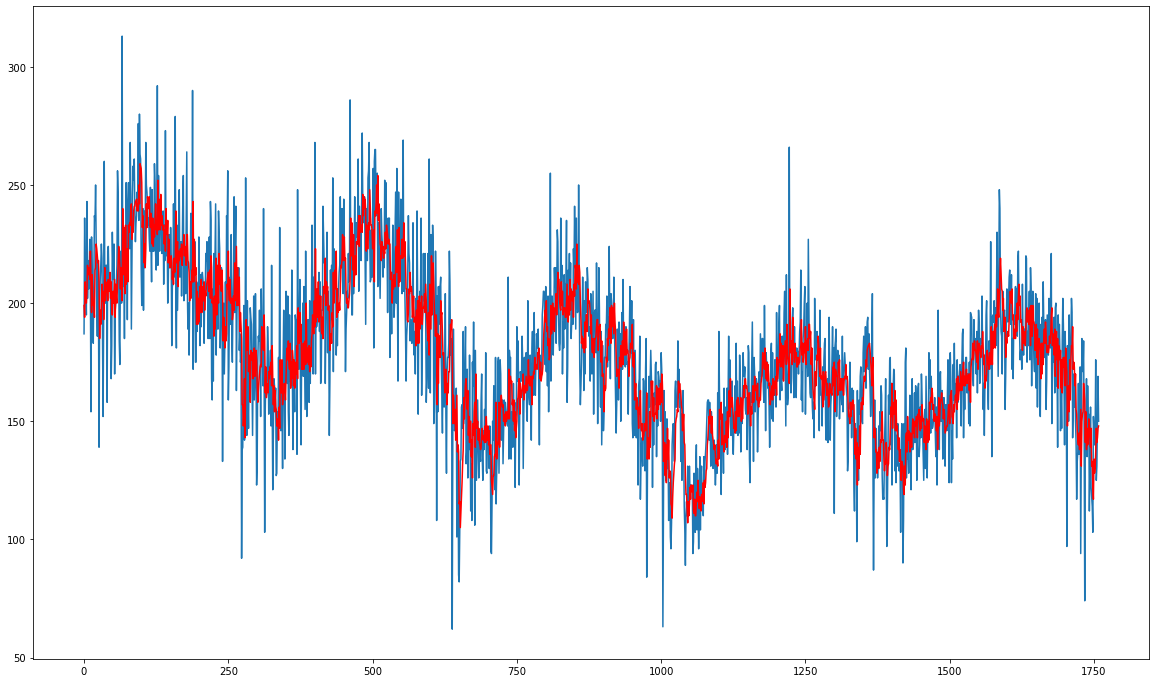

In [37]:
plt.plot(test)
plt.plot(predictions, color = "red")
test.shape

<BarContainer object of 1759 artists>

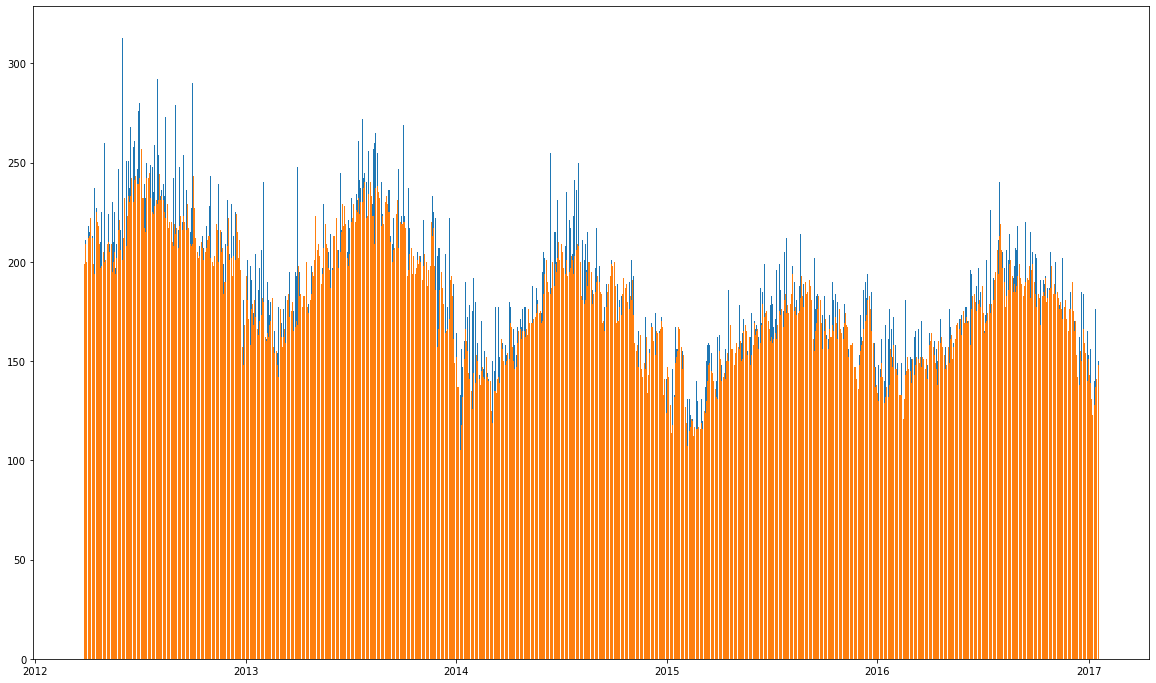

In [38]:
#plt.bar(df2.Date, test)
date = df2.Date.values
size = int(len(date) * 0.7)
test1 = date[size:len(date)]
plt.bar(test1, test)
predictionsArray = np.array(predictions)
plt.bar(test1, predictionsArray)


<BarContainer object of 1759 artists>

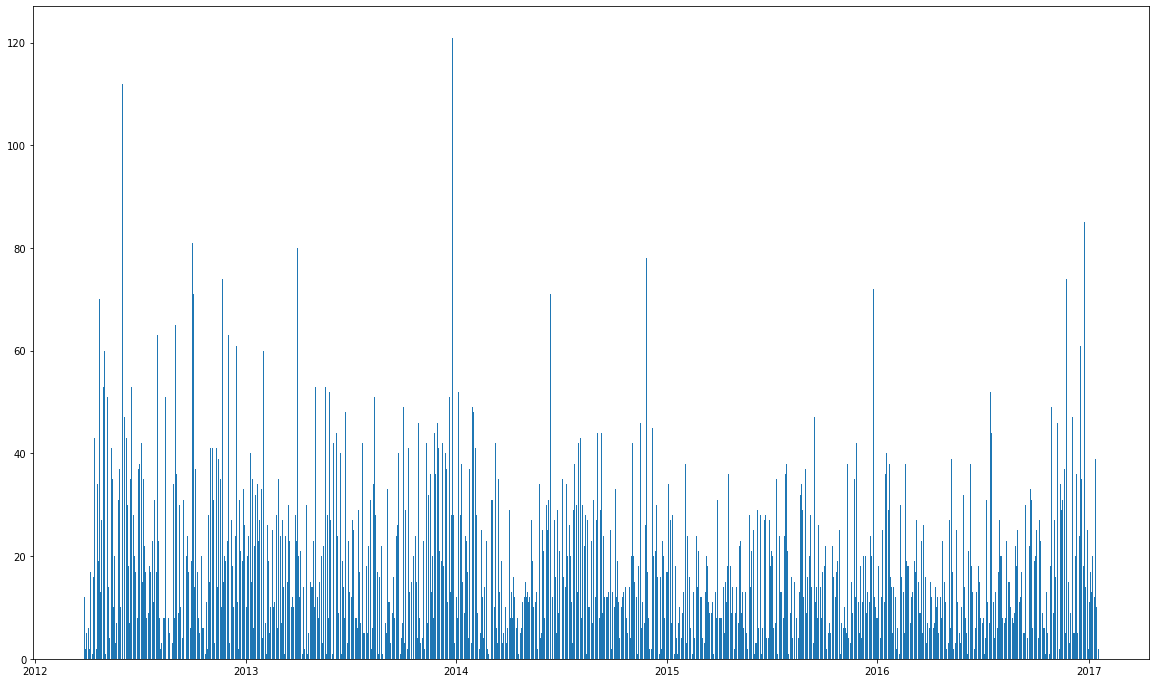

In [49]:
import math
diffBar1 = []
for i in range(len(test)):
  difference = abs(test[i]- predictions[i])
  diffBar1.append(difference)
plt.bar(test1, diffBar1)

<BarContainer object of 55 artists>

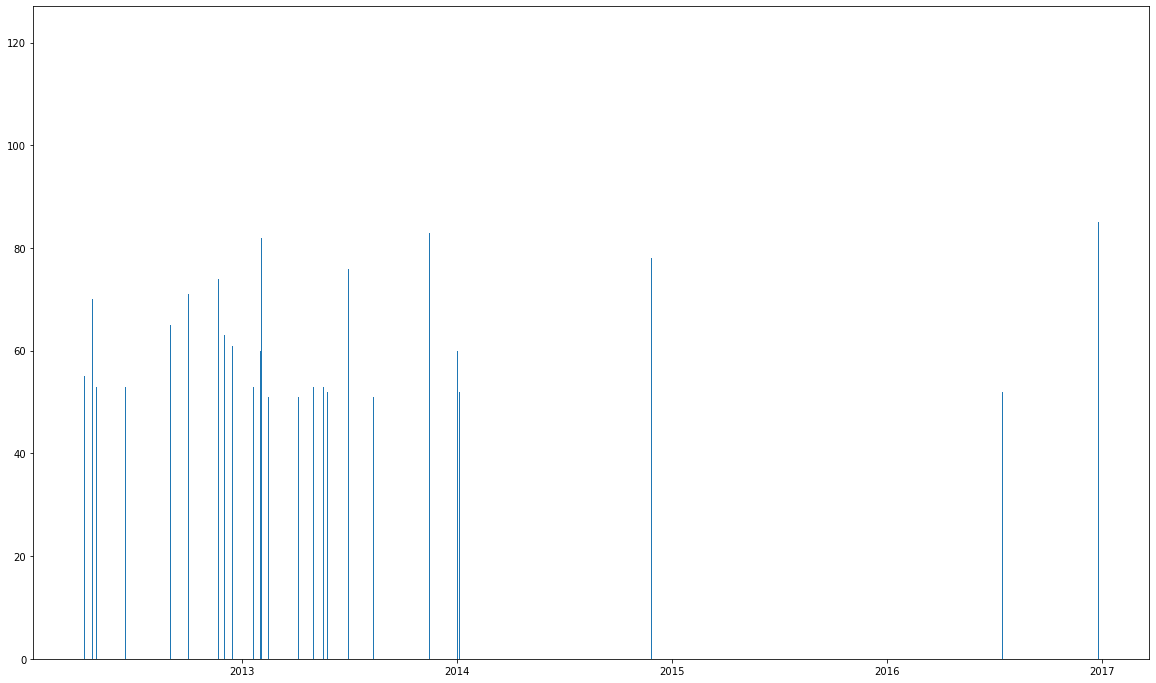

In [47]:
diffBar = []
diffBarX = []
for i in range(len(test)):
  difference = abs(test[i]- predictions[i])
  if difference > 50:
    diffBar.append(difference)
    diffBarX.append(test1[i])
   # print(test1[i].Date)
plt.bar(diffBarX, diffBar)